In [ ]:
#%%

import os
import deeptrack as dt
import torch
import matplotlib.pyplot as plt
import numpy as np
import deeplay as dl
import torch.nn as nn

if not os.path.exists("FashionMNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/FashionMNIST_dataset")

data_dir = "FashionMNIST_dataset"
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(f"Number of train images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

image_pip = (dt.LoadImage(files.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))
label_pip = dt.Value(files.label_name[0]) >> int

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


Number of train images: 60000
Number of test images: 10000


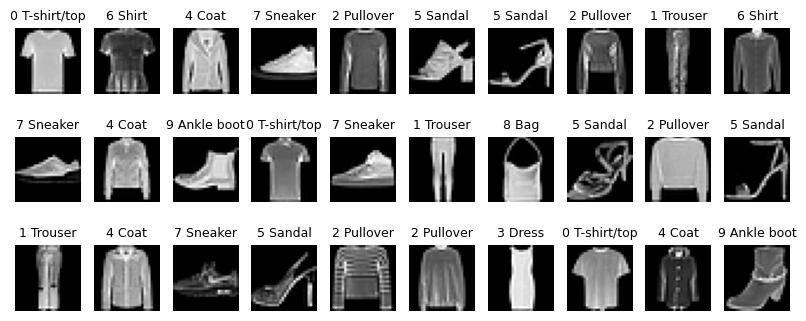

In [ ]:
#%% Plot

fig, axs = plt.subplots(3, 10, figsize=((10, 4)))
for ax, train_file in zip(axs.ravel(),
                          np.random.choice(train_files, axs.size)):
    image, label = (image_pip & label_pip)(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    ax.set_axis_off()
plt.show()

In [ ]:
#%% Make VAE

import deeplay as dl

vae = dl.VariationalAutoEncoder(
    channels=[32, 64], latent_dim=20,
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"),
).create()

print(vae)

train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=train_files)
train_loader = dl.DataLoader(train_dataset, batch_size=128, shuffle=True)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=20, bias=True)
  (fc_var): Linear(in_features=3136, out_features=20, bias=True)
  (fc_dec): Linear(in_features=20, out_features=3136, bias=True)
  (decoder): ConvolutionalDecoder2d(
    

In [ ]:
#%% Training

vae_trainer = dl.Trainer(max_epochs=10)
vae_trainer.fit(vae, train_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K | train
1 | fc_mu               | Linear                 | 62.7 K | train
2 | fc_var              | Linear                 | 62.7 K | train
3 | fc_dec              | Linear                 | 65.9 K | train
4 | decoder             | ConvolutionalDecoder2d | 76.3 K | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   |

Training: |          | 0/? [00:00<?, ?it/s]

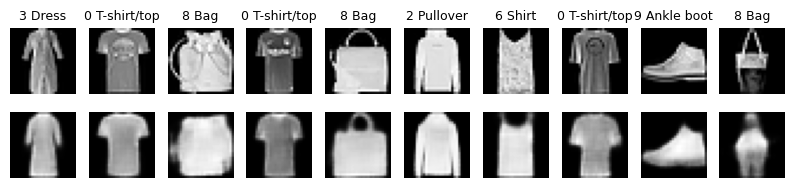

In [ ]:
#%% Reconstruction

vae.eval()
fig, axs = plt.subplots(2, 10, figsize=((10, 2)))
for i, test_file in enumerate(np.random.choice(test_files, 10)):
    image, label = (image_pip & label_pip)(test_file)
    axs[0, i].imshow(image.squeeze(), cmap="gray")
    axs[0, i].set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    axs[0, i].set_axis_off()

    reconstructed_image, _, _ = vae(image.unsqueeze(0))
    axs[1, i].imshow(reconstructed_image.detach().squeeze(), cmap="gray")
    axs[1, i].set_axis_off()
plt.show()

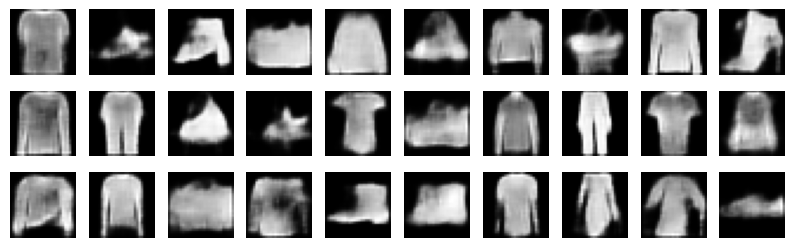

In [ ]:
#%% Latent space

images = vae.decode(torch.randn(30, vae.latent_dim)).detach().squeeze()

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, image in zip(axs.ravel(), images):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()
plt.show()

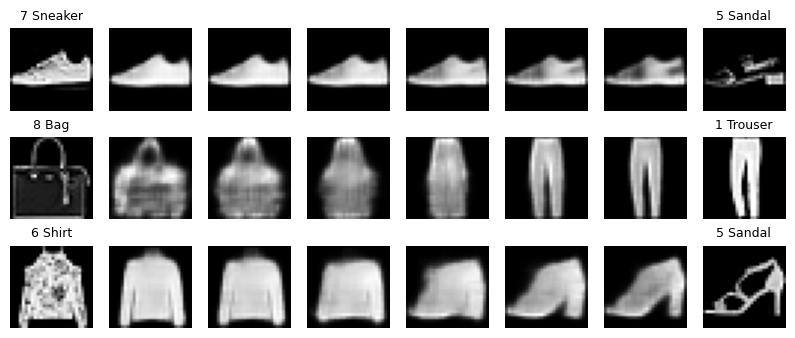

In [ ]:
#%% Latent interpolation

steps = 6
fig, axs = plt.subplots(3, steps + 2, figsize=((10, 4)))
for i in range(3):
    test_file_0, test_file_1 = np.random.choice(test_files, 2)
    image_0, label_0 = (image_pip & label_pip)(test_file_0)
    mu_0, log_var_0 = vae.encode(image_0.unsqueeze(0))
    z_0 = vae.reparameterize(mu_0, log_var_0)

    image_1, label_1 = (image_pip & label_pip)(test_file_1)
    mu_1, log_var_1 = vae.encode(image_1.unsqueeze(0))
    z_1 = vae.reparameterize(mu_1, log_var_1)

    axs[i, 0].imshow(image_0.squeeze(), cmap="gray")
    axs[i, 0].set_title(f"{int(label_0)} {classes[int(label_0)]}", fontsize=9)
    axs[i, 0].set_axis_off()

    for step in range(steps):
        alpha = step / (steps + 1)
        z_step = torch.lerp(z_0, z_1, alpha)
        image_step = vae.decode(z_step).detach()
        axs[i, step + 1].imshow(image_step.squeeze(), cmap="gray")
        axs[i, step + 1].set_axis_off()

    axs[i, -1].imshow(image_1.squeeze(), cmap="gray")
    axs[i, -1].set_title(f"{int(label_1)} {classes[int(label_1)]}", fontsize=9)
    axs[i, -1].set_axis_off()
plt.show()